In [9]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [1]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import pandas as pd
path="C:/Users/pc/Downloads/Data_MASI.xlsx"
data=pd.read_excel(path, index_col=0)
import os
path="C:/Users/pc/Desktop/Stage d'application/Library Python"  # l'espace de travail 
os.chdir(path)
import at_v01  as at  


In [3]:
df=data["COURS_CLOTURE"].loc["2002-01-01":]
high=data["COURS_PLUS_HAUT"].loc["2002-01-01":]
low=data["COURS_PLUS_BAS"].loc["2002-01-01":]
vol=data["Volume_Marche_Bloc"].loc["2002-01-01":] + data["Volume_Marche_Central"].loc["2002-01-01":]

## Fonction

In [11]:
premier=0 

In [12]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness opar générations')
		plt.show()
	main()

In [13]:
ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

## MMS1

In [14]:
def obj_mms(n):
    n=int(n[0])
    signal=pd.DataFrame(index=df.index)
    signal['signal']=0
    signal["compa"]=0
    MMS=at.mms(df,n)["MMS"]
    signal["compa"].loc[n:]=np.where(df[n:] > MMS[n:],1,0)
    signal["signal"]=at.adjustsignal(signal["compa"].diff())
    cours=df*(1+taux*signal["signal"])
    pmval=at.pmv(cours,signal["signal"])
    pmval=pd.Series(pmval,index=df.index)
    return pmval.max(), 

gen	nevals	max    	avg 
0  	40    	10859.8	9381
1  	36    	10883.4	9869.56
2  	38    	10883.4	10315.2
3  	38    	10883.4	10712.5
4  	38    	10883.4	10862.3
5  	35    	10883.4	10878  
6  	34    	10883.4	10882.8
7  	32    	10883.4	10883.4
8  	36    	10883.4	10816.5
9  	38    	10883.4	10831.7
10 	40    	10883.4	10883.4
Hall of Fame Individuals = 
[26.036204684036537]
[26.141049409069772]
[26.918530658523842]
[26.112319992621703]
[26.914674156440377]
Best Ever Individual =  [26]


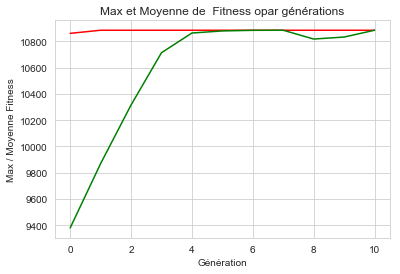

In [15]:
GeneticAlgo(1,obj_mms,10,5,100)

## MMS2

In [16]:
def obj_mms2(n):
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
	signal=pd.DataFrame(index=df.index)
	signal['compa']=np.nan
	signal["MMS_COURT"]=at.mms(df,ws)["MMS"]
	signal["MMS_LONG"]=at.mms(df,wl)["MMS"]
	signal["compa"].loc[wl:]=np.where(signal["MMS_COURT"][wl:] > signal["MMS_LONG"][wl:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg   
0  	40    	12476.2	8458.7
1  	37    	12735.6	8980.36
2  	34    	12735.6	10776.8
3  	36    	12735.6	12072  
4  	34    	12735.6	12443.1
5  	37    	12735.6	12654.3
6  	38    	12735.6	12703.1
Hall of Fame Individuals = 
[37.773422189350576, 6.43128985214098]
[37.773422795595216, 6.43128985214098]
[37.706712775791466, 6.45935584762455]
[37.967639916382275, 6.43128985214098]
[37.758886272331985, 6.43128985214098]
Best Ever Individual =  [37, 6]


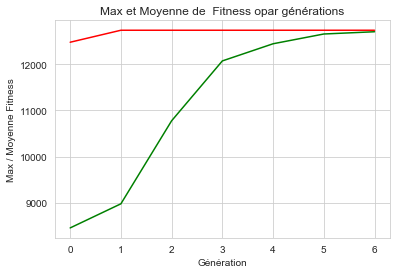

In [25]:
GeneticAlgo(2,obj_mms2,6,5,50)

## MACD1

In [18]:
def obj_macd1(n):
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
	signal=pd.DataFrame(index=df.index)
	MACD=at.macd(df,ws,wl)["MACD"]
	signal["compa"]=np.nan
	signal["compa"][wl:]=np.where(MACD[wl:]>0 ,1 ,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max  	avg    
0  	40    	12924	10246.9
1  	38    	12924	10958.4
2  	32    	12968.1	11457  
3  	34    	13055  	11898  
4  	38    	13055  	12340.6
5  	36    	13055  	12826.1
6  	37    	13055  	13002.6
Hall of Fame Individuals = 
[13.740822587885967, 22.158859547682127]
[13.096400500121517, 22.117869798964662]
[13.723691910127501, 22.156906530147893]
[13.723547166358564, 22.143888063254742]
[13.113531177879981, 22.119822816498896]
Best Ever Individual =  [13, 22]


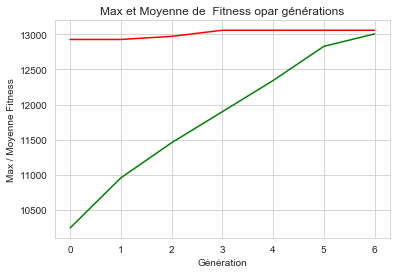

In [24]:
GeneticAlgo(2,obj_macd1,6,10,60)

## MACD2 

In [20]:
def obj_macd2(n):
	ws=int(n[0])
	wl=int(n[1])
	if ws > wl :
		ws,wl=wl,ws
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan
	MACD=at.macd(df,ws,wl)[["MACD","MACDsignal"]]
	signal["compa"][wl:]=np.where(MACD["MACD"][wl:] > MACD["MACDsignal"][wl:] ,1 ,0 )
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	8112.14	6396.28
1  	39    	8140.1 	7133.79
2  	32    	8140.1 	7340.26
3  	37    	8154.52	7836.42
4  	36    	8154.52	7894.68
5  	36    	8154.52	8018.63
6  	38    	8154.52	8072.93
7  	40    	8154.52	8154.52
8  	28    	8154.52	8130.13
9  	35    	8154.52	8126.83
10 	40    	8154.52	8149.17
Hall of Fame Individuals = 
[14.998196003807319, 19.002810876935538]
[14.982187050087992, 19.002726425057478]
[14.998622397924606, 19.005631657543844]
[14.937990333016577, 19.00004443620286]
[14.998563675630315, 19.0027265109099]
Best Ever Individual =  [14, 19]


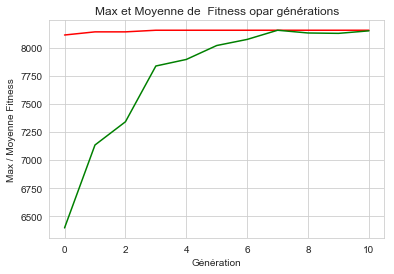

In [21]:
GeneticAlgo(2,obj_macd2,10,12,40)

## Bollinger 

In [26]:
def obj_bollinger(n):
	global k 
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan
	signal["compa2"]=np.nan
	bb=at.bollinger(df,n,k)[["BBDOWN","BBUP"]]
	signal["compa"][n:] = np.where( (df[n:] > bb["BBUP"][n:] ) ,1,0)
	signal["compa2"][n:] = np.where( (df[n:] < bb["BBDOWN"][n:] ) ,4,2)
	signal["signal"]=signal["compa"].diff()
	signal["signal2"]=signal["compa2"].diff()
	sig=np.where(signal["signal"]==1,-1,0)+np.where(signal["signal2"]==2,1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df.index)
	cours=df*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	2254.47	596.198
1  	32    	2254.47	1179.23
2  	38    	2254.47	1834.14
3  	35    	2254.47	2215.89
4  	36    	2254.47	2212.96
5  	33    	2254.47	2242.76
6  	37    	2254.47	2221.75
7  	36    	2254.47	2254.47
8  	38    	2254.47	2174.11
9  	36    	2254.47	2188.18
10 	40    	2254.47	2251.55
Hall of Fame Individuals = 
[28.057862245915747]
[28.020759617201666]
[28.00271936816877]
[28.99728063183123]
[28]
Best Ever Individual =  [28]


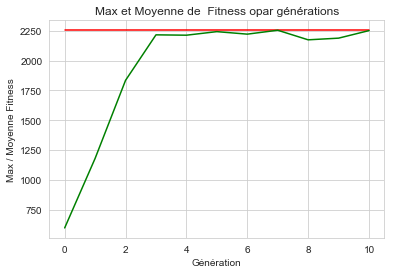

In [27]:
k=2
GeneticAlgo(1,obj_bollinger,10,18,35)

gen	nevals	max    	avg    
0  	40    	21787.1	4556.01
1  	36    	21787.1	10872.1
2  	38    	21787.1	17263.3
3  	37    	21787.1	21190  
4  	38    	21787.1	21751.7
5  	36    	21787.1	21225.1
Hall of Fame Individuals = 
[39.01112365842774]
[39.958949896560476]
[39.02197218058599]
[39.08070285752669]
[39]
Best Ever Individual =  [39]


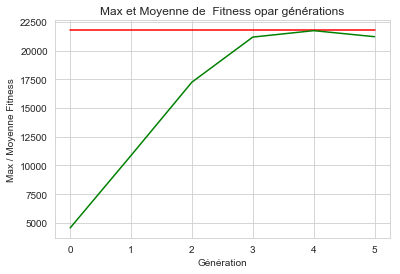

In [29]:
k=2.5
GeneticAlgo(1,obj_bollinger,5,20,60)

gen	nevals	max  	avg    
0  	40    	25776	4412.75
1  	36    	25776	9930.33
2  	40    	25776	15423.1
3  	37    	25776	20234.9
4  	38    	25776	23217.8
5  	33    	25776	25652.4
Hall of Fame Individuals = 
[21.167660301374372]
[21.391450146182066]
[21.16691207269481]
[21.032796705588474]
[21]
Best Ever Individual =  [21]


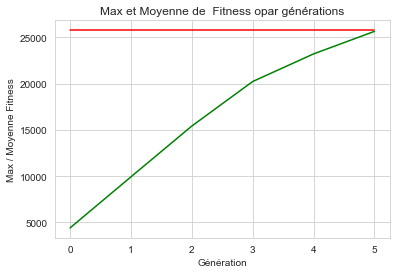

In [30]:
k=3 
GeneticAlgo(1,obj_bollinger,5,20,60)

## RSI

In [31]:
def  obj_rsi(n):
	global haut
	global bas
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	rs=at.rsi(df,n)["RSI"]
	signal["compa_achat"]=np.nan
	signal["compa_vente"]=np.nan
	signal["compa_achat"][n:]=np.where(rs[n:] > bas,1,0)
	signal["signal_achat"]=signal["compa_achat"].diff()
	signal["compa_vente"][n:]=np.where(rs[n:] < haut,4,2)
	signal["signal_vente"]=signal["compa_vente"].diff()
	sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df.index)
	cours=df*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	19271.1	8965.04
1  	33    	19271.1	12774.4
2  	40    	19271.1	16866.2
3  	37    	19271.1	17392.3
4  	38    	19271.1	18246.2
5  	37    	19271.1	18587.8
Hall of Fame Individuals = 
[27.00044664357844]
[27.038328183990888]
[27.00116476565021]
[27.15831406207636]
[27]
Best Ever Individual =  [27]


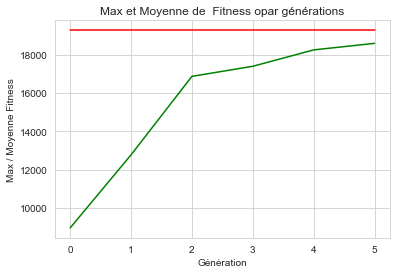

In [33]:
haut,bas=0.7,0.3
GeneticAlgo(1,obj_rsi,5,13,30)

gen	nevals	max    	avg    
0  	40    	8540.45	4233.51
1  	33    	8540.45	4828.51
2  	40    	8540.45	5759.53
3  	37    	8540.45	6493.81
4  	38    	8540.45	7832   
5  	33    	8540.45	8285.93
Hall of Fame Individuals = 
[21.9745811408688]
[21.914348685947953]
[21.96358497649986]
[21.781604036198274]
[21]
Best Ever Individual =  [21]


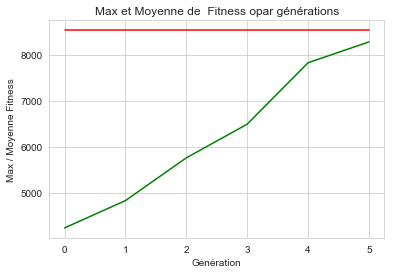

In [34]:
haut,bas=0.75,0.25
GeneticAlgo(1,obj_rsi,5,13,30)

gen	nevals	max    	avg    
0  	40    	7730.53	3761.27
1  	32    	7730.53	4791.61
2  	38    	7730.53	5996.6 
3  	35    	7730.53	7234.45
4  	36    	7730.53	7406.72
5  	38    	7730.53	7487.68
Hall of Fame Individuals = 
[23.663229462936016]
[23.020759617201666]
[23.00271936816877]
[23.99728063183123]
[23]
Best Ever Individual =  [23]


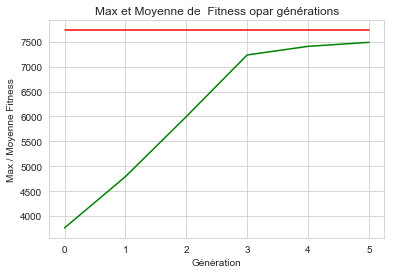

In [35]:
haut,bas=0.8,0.20
GeneticAlgo(1,obj_rsi,5,13,30)

gen	nevals	max    	avg    
0  	40    	2181.39	868.049
1  	32    	2181.39	1686.24
2  	38    	2181.39	2113.75
3  	35    	2181.39	2160.41
4  	38    	2181.39	2181.39
5  	36    	2181.39	2181.39
6  	35    	2181.39	2181.39
Hall of Fame Individuals = 
[13.554955751424165]
[13.021200776572329]
[13.117562101225342]
[13.837277706937734]
[13]
Best Ever Individual =  [13]


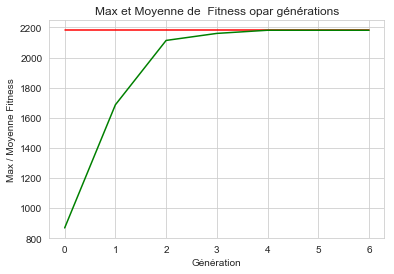

In [36]:
haut,bas=0.85,0.15
GeneticAlgo(1,obj_rsi,6,13,30)

gen	nevals	max   	avg    
0  	40    	5522.2	1674.69
1  	36    	5522.2	3570.23
2  	38    	5522.2	4966.47
3  	35    	5522.2	5219.15
4  	40    	5522.2	4888.49
5  	36    	5522.2	5268.71
6  	36    	5522.2	5268.71
Hall of Fame Individuals = 
[27.004216320007412]
[27.044630291080868]
[27.038328183990888]
[27.011528979646645]
[27]
Best Ever Individual =  [27]


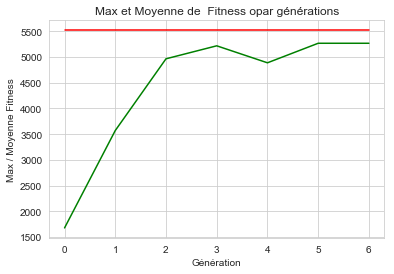

In [37]:
haut,bas=0.9,0.1
GeneticAlgo(1,obj_rsi,6,13,30)

## Stochastique 1 

In [38]:
df1=data["COURS_CLOTURE"].loc["2008-01-01":]
high1=data["COURS_PLUS_HAUT"].loc["2008-01-01":]
low1=data["COURS_PLUS_BAS"].loc["2008-01-01":]
vol1=data["Volume_Marche_Bloc"].loc["2008-01-01":] + data["Volume_Marche_Central"].loc["2008-01-01":]

In [39]:
def obj_stochastique1(n):
	global haut
	global bas
	n=int(n[0])
	signal=pd.DataFrame(index=df1.index)
	k=at.stochastique(df1 ,high1,low1, n , 3)["%K"]
	signal["compa_achat"]=np.nan
	signal["compa_vente"]=np.nan
	signal["compa_achat"][n:]=np.where(k[n:] > bas,1,0)
	signal["signal_achat"]=signal["compa_achat"].diff()
	signal["compa_vente"][n:]=np.where(k[n:] < haut,4,2)
	signal["signal_vente"]=signal["compa_vente"].diff()
	sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df1.index)
	cours=df1*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	99793.7	53686.5
1  	36    	99793.7	73209.4
2  	37    	99793.7	94390.9
3  	37    	99793.7	97748.4
4  	40    	99793.7	99442.5
5  	38    	99793.7	98740.2
6  	35    	99793.7	97385.3
7  	35    	99793.7	99357.7
8  	39    	99793.7	97829  
9  	36    	99793.7	98389  
10 	31    	99793.7	99793.7
Hall of Fame Individuals = 
[17.919334156751997]
[17.96685189632885]
[17.9978682618566]
[17.988601798793958]
[17]
Best Ever Individual =  [17]


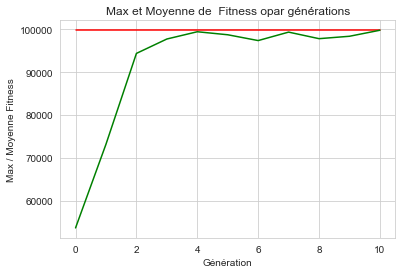

In [40]:
haut,bas=70,30
GeneticAlgo(1,obj_stochastique1,10,12,30)

gen	nevals	max   	avg    
0  	40    	106423	72012.8
1  	36    	106423	95141.1
2  	36    	106423	101849 
3  	38    	106423	104020 
4  	38    	106423	105545 
5  	36    	106423	105979 
6  	35    	106423	105920 
Hall of Fame Individuals = 
[19.77959592459486]
[19.928022220991803]
[19.07007538924168]
[19.06966466799333]
[19]
Best Ever Individual =  [19]


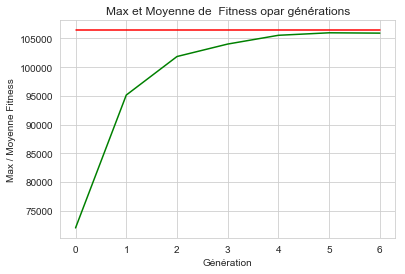

In [41]:
haut,bas=75,25
GeneticAlgo(1,obj_stochastique1,6,12,30)

gen	nevals	max   	avg    
0  	40    	122461	90004.4
1  	36    	122955	107308 
2  	36    	118507	113912 
3  	38    	122955	118442 
4  	38    	122955	119260 
5  	36    	122955	121065 
6  	35    	122955	122286 
Hall of Fame Individuals = 
[24.972246185419596]
[24.99663949204258]
[24.97401222030901]
[24.97016478622455]
[24.982902698190937]
Best Ever Individual =  [24]


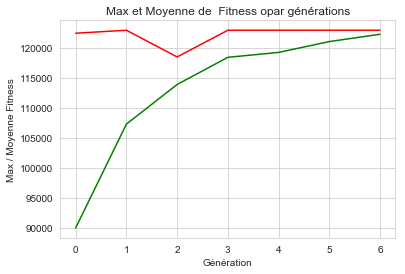

In [42]:
haut,bas=80,20
GeneticAlgo(1,obj_stochastique1,6,12,30)

gen	nevals	max   	avg    
0  	40    	104616	55052.2
1  	36    	122796	80549.4
2  	36    	122796	98457.8
3  	38    	122796	107055 
4  	40    	122796	117796 
5  	36    	122796	121887 
6  	34    	122796	122796 
Hall of Fame Individuals = 
[29.97749315774866]
[29.924469964069907]
[29.93203783236319]
[29.955043778423793]
[29.972881863644258]
Best Ever Individual =  [29]


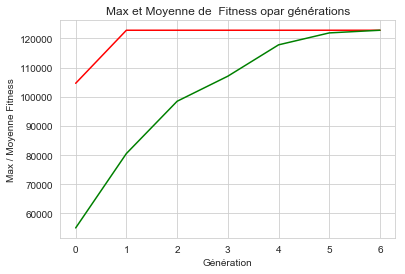

In [43]:
haut,bas=85,15
GeneticAlgo(1,obj_stochastique1,6,12,30)

gen	nevals	max    	avg    
0  	40    	85015.5	49726.7
1  	36    	85015.5	68298  
2  	36    	85015.5	78605.4
3  	39    	85015.5	81681.8
4  	38    	85015.5	82052.8
5  	35    	85015.5	83369.5
6  	37    	85015.5	84550.9
Hall of Fame Individuals = 
[30]
[25.973595621473944]
[25.954407150280392]
[25.204142596504358]
[25]
Best Ever Individual =  [30]


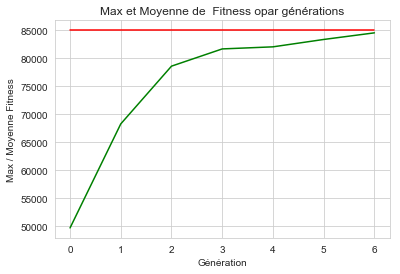

In [44]:
haut,bas=90,10
GeneticAlgo(1,obj_stochastique1,6,12,30)

## Stochastique 2

In [45]:
def obj_stochastique2(n ):
	n.sort()
	w=int(n[0])
	n=int(n[1])
	signal=pd.DataFrame(index=df1.index)
	k=at.stochastique(df1 ,high1,low1, n , w)[["%K","%D"]]
	signal["compa"]=np.nan
	signal["compa"][n+w :]=np.where(k["%K"][n+w:] > k["%D"][n+w:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df1*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	363.536	148.409
1  	36    	363.536	191.662
2  	40    	363.536	219.29 
3  	38    	363.536	265.516
4  	34    	363.536	291.195
5  	37    	363.536	339.643
6  	38    	363.536	349.87 
Hall of Fame Individuals = 
[9.064345322627561, 27]
[7, 27.007042272250434]
[7, 27.002199996772518]
[9.021856188829561, 26.010846767370175]
[7, 27]
Best Ever Individual =  [9, 27]


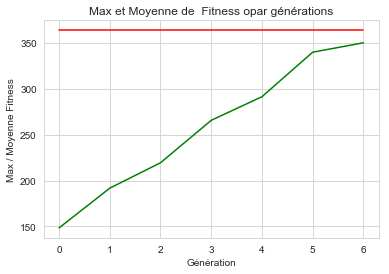

In [46]:
GeneticAlgo(2,obj_stochastique2,6,3,30)

## OBV

In [47]:
def obj_obv(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	ob=at.obv(df,vol)["OBV"]
	obs=pd.Series(ob.rolling(n).mean(), name='obvsignal')
	signal["compa"]=np.nan 
	signal["compa"][n:]=np.where( ob[n:]  > obs[n:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max   	avg    
0  	40    	5710.3	3323.86
1  	35    	5710.3	4130.23
2  	38    	5710.3	4701.1 
3  	36    	5710.3	4946.22
4  	40    	5710.3	5342.56
5  	36    	5710.3	5381.72
6  	35    	5710.3	5453.75
Hall of Fame Individuals = 
[32.00117617118097]
[32]
[30.03476200420938]
[10.489186803722037]
[10.105610197964031]
Best Ever Individual =  [32]


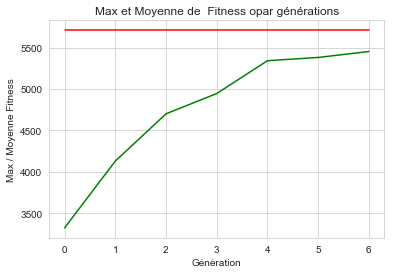

In [48]:
GeneticAlgo(1,obj_obv,6,10,100)

## ROC

In [49]:
def obj_roc(n):
	w=int(n[0])
	signal=pd.DataFrame(index=df.index)
	roc=at.rate_of_change(df,w)["ROC"]
	signal["compa"]=np.nan
	signal["compa"][w:]=np.where( roc[w:]> 0,1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	9247.61	8680.78
1  	36    	9247.61	8928.54
2  	36    	9817.07	9185.35
3  	38    	9817.07	9278.41
4  	40    	9817.07	9371.07
5  	35    	9817.07	9482.12
6  	35    	9817.07	9681.22
7  	32    	9817.07	9817.07
8  	38    	9817.07	9796.83
9  	36    	9817.07	9817.07
10 	32    	9817.07	9817.07
Hall of Fame Individuals = 
[12.859059653692416]
[12.831747108423938]
[12.810449754080768]
[12.783243796171122]
[12.960617592581624]
Best Ever Individual =  [12]


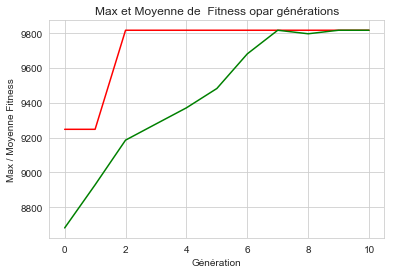

In [50]:
GeneticAlgo(1,obj_roc,10,10,30)

## MFI

In [51]:
def obj_mfi(n):
	global haut
	global bas
	n=int(n[0])
	signal=pd.DataFrame(index=df1.index)
	mfi=at.MFI(df1,vol1,high1,low1,n)['MFI']
	signal["compa_achat"]=np.nan
	signal["compa_vente"]=np.nan
	signal["compa_achat"][n:]=np.where(mfi[n:] > bas,1,0)
	signal["signal_achat"]=signal["compa_achat"].diff()
	signal["compa_vente"][n:]=np.where(mfi[n:] < haut,4,2)
	signal["signal_vente"]=signal["compa_vente"].diff()
	sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df1.index)
	cours=df1*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	42020.2	14632.1
1  	38    	42020.2	21588.2
2  	38    	42020.2	29387.1
3  	38    	42020.2	37138.1
4  	38    	42020.2	41746  
5  	36    	42020.2	41746  
6  	35    	42020.2	42020.2
Hall of Fame Individuals = 
[10.31796827195453]
[10.049935500799986]
[10.965167666003335]
[10.318712013241512]
[10]
Best Ever Individual =  [10]


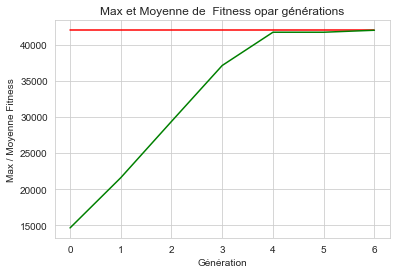

In [52]:
haut,bas=80,20
GeneticAlgo(1,obj_mfi,6,10,30)

gen	nevals	max    	avg    
0  	40    	45035.1	23226.1
1  	36    	45035.1	34671.9
2  	36    	45035.1	40334.8
3  	38    	45035.1	42473.1
4  	38    	45035.1	41625  
5  	36    	45035.1	43330  
6  	35    	45035.1	43898.4
Hall of Fame Individuals = 
[20.669853613610556]
[20.021899954263507]
[20.03419460361813]
[20.63510010855244]
[20]
Best Ever Individual =  [20]


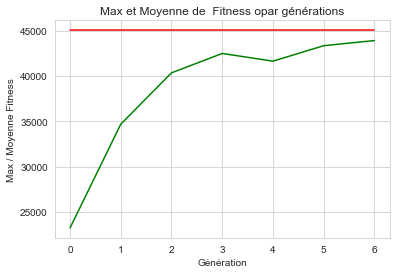

In [53]:
haut,bas=70,30
GeneticAlgo(1,obj_mfi,6,10,30)

## CHO

In [54]:
def obj_cho(ind):
	ind.sort()
	ws=int(ind[0])
	wl=int(ind[1])
	n=int(ind[2])
	signal=pd.DataFrame(index=df1.index)
	signal["compa"]=np.nan 
	ch=at.cho(df1,vol1,high1,low1,n,ws,wl)["CHO"]
	signal["compa"][ws+wl:]=np.where(ch[ws+wl:] > 0, 1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df1*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max   	avg    
0  	40    	427.83	138.501
1  	40    	521.113	179.623
2  	38    	521.113	251.153
3  	38    	521.113	259.294
4  	36    	521.113	327.132
5  	37    	521.113	456.39 
6  	36    	521.113	488.085
7  	40    	521.113	518.789
8  	36    	521.113	510.941
9  	40    	521.113	510.941
10 	40    	521.113	521.113
Hall of Fame Individuals = 
[3.697884543239409, 9.88122522392246, 11.639395050203452]
[6.889964002954178, 10, 11.649355217053241]
[3.5248337040231235, 11.520422679351134, 11.639395050203452]
[3.9298560563387746, 10.06838933817701, 11.555092248523275]
[3.5248337040231235, 10.179838940541956, 11.639395050203452]
Best Ever Individual =  [3, 9, 11]


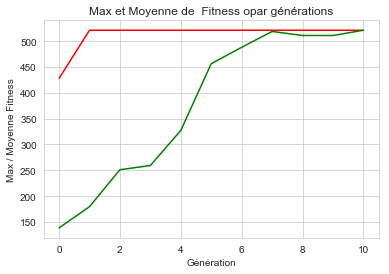

In [55]:
GeneticAlgo(3,obj_cho,10,3,30)

## NVI

In [56]:
def obj_nvi(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan 
	nv=at.nvi(df,vol)
	nvis=pd.Series(nv.rolling(n).mean(), name="NVIsignal")
	signal["compa"][n:]=np.where(nv[n:] > nvis[n:] ,1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	168.877	5.76396
1  	36    	168.877	16.8261
2  	38    	168.877	45.0354
3  	36    	168.877	92.1703
4  	36    	168.877	138.269
5  	38    	168.877	154.463
Hall of Fame Individuals = 
[49.58139613221198]
[49.01842052128876]
[49.26650626329102]
[49.711099704172426]
[49]
Best Ever Individual =  [49]


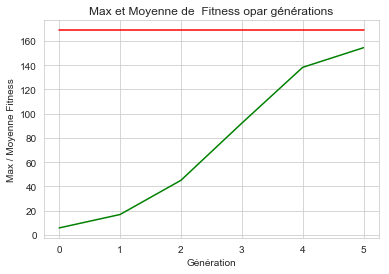

In [64]:
GeneticAlgo(1,obj_nvi,5,8,50)

## PVI

In [58]:
def obj_pvi(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan 
	pv=at.pvi(df,vol)
	pvis=pd.Series(pv.rolling(n).mean(), name="NVIsignal")
	signal["compa"][n:]=np.where(pv[n:] > pvis[n:] ,1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	144.149	7.25749
1  	36    	144.149	3.66377
2  	38    	144.149	3.74384
3  	37    	0.40034	0.300255
4  	38    	0.40034	0.390331
5  	38    	0.40034	0.40034 
Hall of Fame Individuals = 
[50]
[10.074612506915397]
[11]
[9]
[10]
Best Ever Individual =  [50]


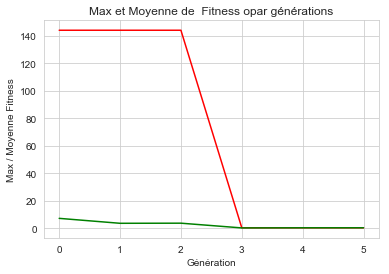

In [65]:
GeneticAlgo(1,obj_pvi,5,8,50)

In [60]:
## Momentum 

In [61]:
def obj_momentum(n):
	w=int(n[0])
	MOM=at.momentum(df,w,wsig=9)[["MOM","MOMsignal"]]
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan
	signal["compa"][w:]=np.where(MOM["MOM"][w:] > MOM["MOMsignal"][w:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	6582.17	5225.14
1  	35    	7189.18	5654.06
2  	38    	6582.17	6145.07
3  	38    	6582.17	6398.93
4  	40    	6582.17	6418.59
5  	33    	6582.17	6489.82
Hall of Fame Individuals = 
[20.966994526842427]
[30]
[17.987485740420823]
[17.985773578769837]
[17]
Best Ever Individual =  [20]


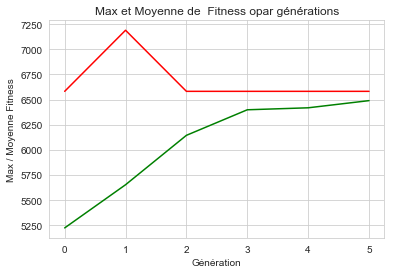

In [62]:
GeneticAlgo(1,obj_momentum,5,8,30)